# Statistics for low number of experimental repetitions

*Davi R. Ortega*

A common problem to make statistical tests in Biology. Each experiment is time consuming and more often than not, we see papers reporting bar plots with error bars calculated from n=3 experiments. Even worse is the use of parametric tests (tests that assume that the distribution of the data is normal) to validate statistical significance of differences in the averages when comparing two settings, each repeated three times.

Here, we will show:
*   How low sampling can be misleading
*   Better ways to report uncertainty
*   How parametric tests can be misleading
*   Better alternatives to "put a number" in how different are two sets of measurements.


Let's start from a hypothetical story that we know the real truth. Let's suppose that the entire population of four new species of bacteria that was discovered: **A** and **B**. Each population has a convenient number of 1000 cells. Now, we will characterize the cellular size of each species.


## Coding some Python

Below you will find a code that will allow us to create our environment of two populations of cells with different size distributions.

In [1]:
import numpy
import pandas
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", palette="muted", color_codes=True)
        
class Population (object):
    "Define the population class."
    def __init__(self, name, sizes = [], color = 'b'):
        "Initialize attributes"
        self.name = name
        self.sizes = numpy.array(sizes)
        self.aveSiz = numpy.average(sizes)
        self.sortSiz = numpy.sort(self.sizes)
        self.color = color
        self.stored = []

    def storeSample(self, n):
        "Initialize methods"
        self.stored = numpy.random.choice(self.sizes, n)
        return self.stored
    
    def showSum(self):
        import seaborn as sns
        import matplotlib.pyplot as plt

        sns.set(style="white", palette="muted", color_codes=True)
        f, axes = plt.subplots(1, 3, figsize=(10, 3))
        
        sns.distplot(self.sizes, kde=False, color=self.color, ax=axes[0], axlabel = 'hist')
        sns.violinplot(data = self.sizes, ax=axes[1], color=self.color)
        axes[2].plot(self.sortSiz, color=self.color)
        plt.show()

def compare(A, B):
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.set(style="white", palette="muted", color_codes=True)
    
    AB = pandas.DataFrame({ A.name : A.sizes, B.name: B.sizes})
    ABmelt = pandas.melt(AB)
    ABmelt['sample'] = 'yes'
    f, axes = plt.subplots(1, 3, figsize=(10, 3), sharey = True)
    sns.violinplot(data = AB, ax=axes[0])
    sns.violinplot(data = ABmelt, ax=axes[1], split = True, x = 'sample', y = 'value', hue = 'variable', palette={ A.name: A.color, B.name: B.color})
    plt.show()
    
    return AB

def samplePops(pops = [], n = 3):
    for pop in pops:
        pop.storeSample(n)
        print('Population {:s} => {:.2} +- {:.2}'.format(pop.name, pop.stored.mean(), pop.stored.std()))
    return None

def plotSample(pops = []):
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.set(style="white", palette="muted", color_codes=True)
    stored = []
    for pop in pops:
        stored.append(pop.stored)
    f, axes = plt.subplots(1, 2, figsize=(10, 3), sharey = True)
    sns.barplot(data = stored, ax = axes[0])
    sns.swarmplot(data = stored, ax = axes[1])
    plt.show()

## Creating the populations of cells.

As anything in biology, sizes of organisms obey some distribution. Not all cells are exactly the same size. Here we will use the $\beta$ distribution to build a population of cell sizes.

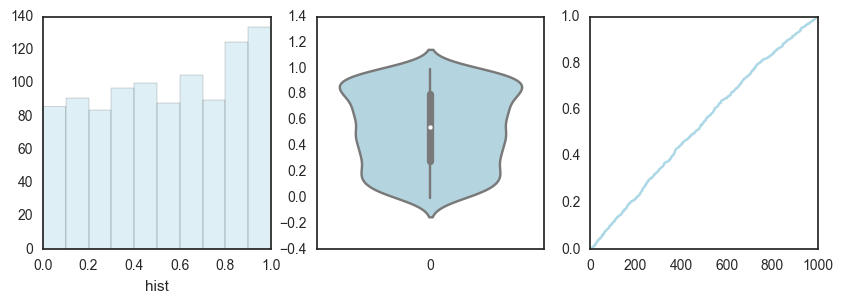

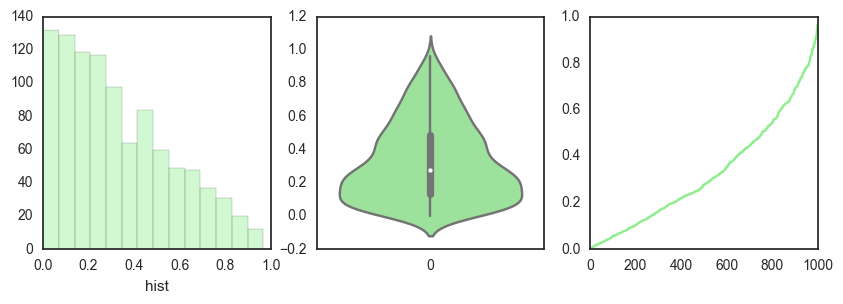

In [2]:
distrA = numpy.random.beta(1, 0.9, 1000)
A = Population(name = 'A', sizes = distrA, color = 'lightblue')
A.showSum()

distrB = numpy.random.beta(1, 2, 1000)
B = Population(name = 'B', sizes = distrB, color = 'lightgreen')
B.showSum()

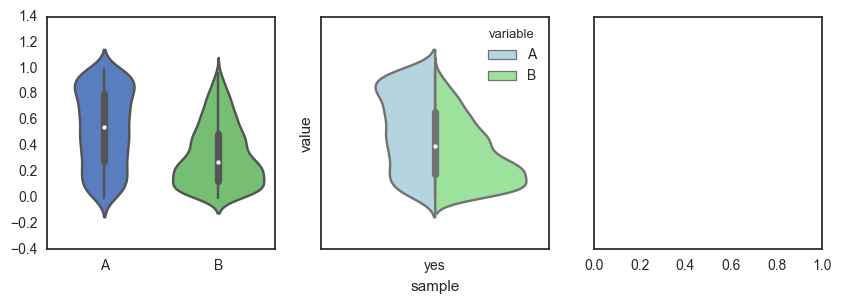

In [3]:
AB = compare(A, B)

Notice how different the distribution of sizes are form the two samples. This is what we will consider the reality. Now let's make some measurements of the cell sizes in each population.

## Sampling the data

Now that we have our populations, let's randomnly measure 3 cells per population, because... you know... it is hard to measure cells.

But since we are making an *in silica* experiment, let's do the drill to do the whole ordeal of measuring and calculating the statistics 10 times. 

Let's see if we get the same results every time. 

*Also, let's perform several significance tests* - **TODO**

Executing the 3 measurements and ploting the results :: 0
Population A => 0.54 +- 0.36
Population B => 0.31 +- 0.078


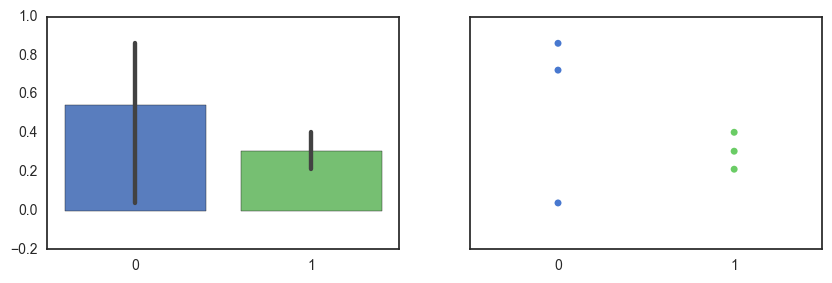

Executing the 3 measurements and ploting the results :: 1
Population A => 0.49 +- 0.33
Population B => 0.42 +- 0.32


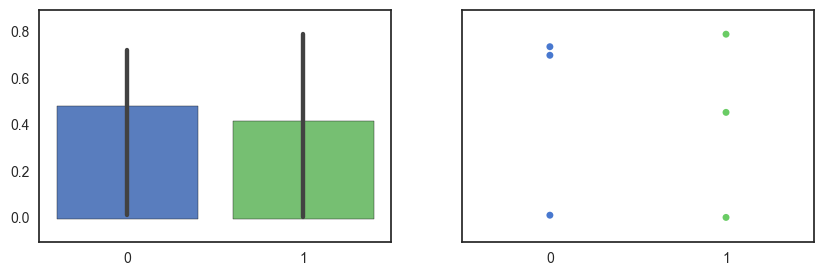

Executing the 3 measurements and ploting the results :: 2
Population A => 0.7 +- 0.21
Population B => 0.27 +- 0.11


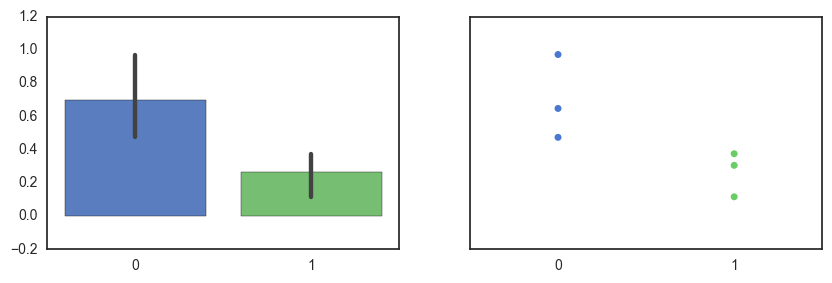

Executing the 3 measurements and ploting the results :: 3
Population A => 0.79 +- 0.045
Population B => 0.41 +- 0.3


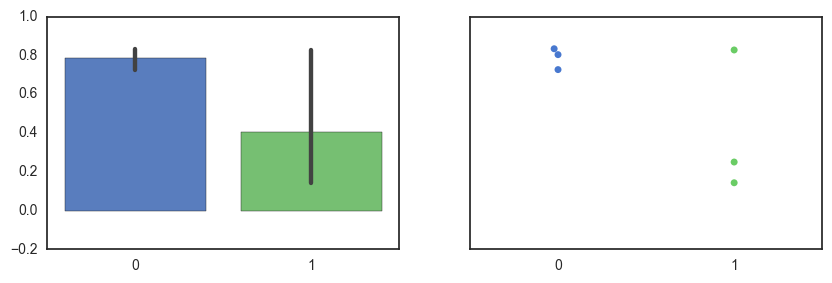

Executing the 3 measurements and ploting the results :: 4
Population A => 0.54 +- 0.33
Population B => 0.37 +- 0.29


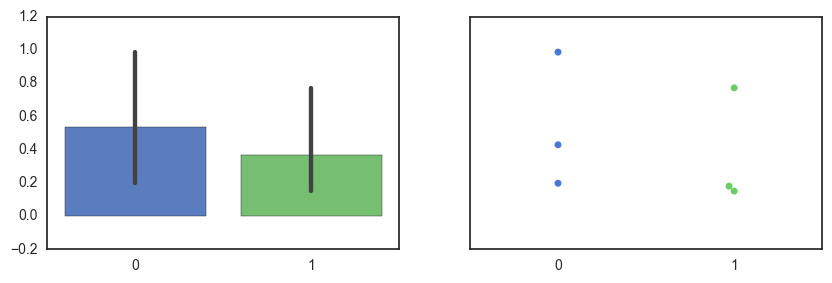

Executing the 3 measurements and ploting the results :: 5
Population A => 0.64 +- 0.43
Population B => 0.44 +- 0.18


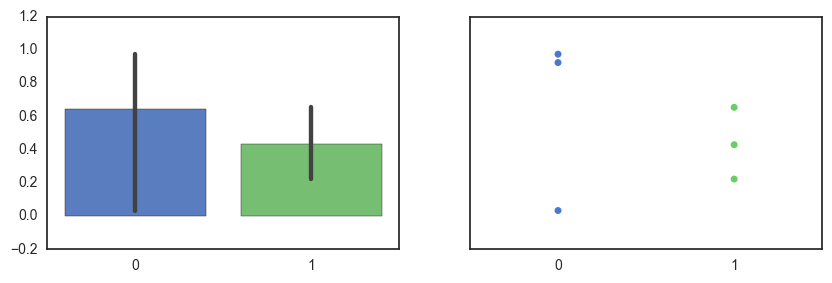

Executing the 3 measurements and ploting the results :: 6
Population A => 0.29 +- 0.18
Population B => 0.12 +- 0.052


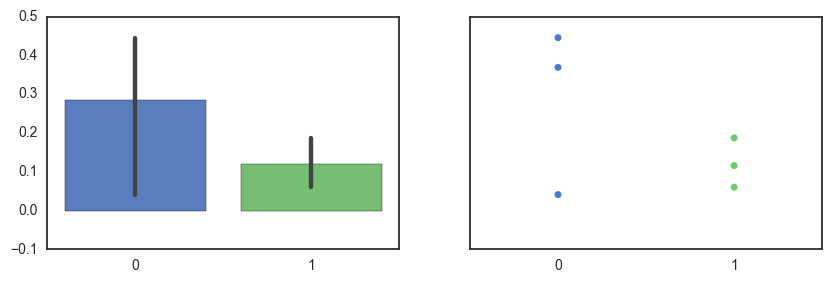

Executing the 3 measurements and ploting the results :: 7
Population A => 0.68 +- 0.23
Population B => 0.23 +- 0.13


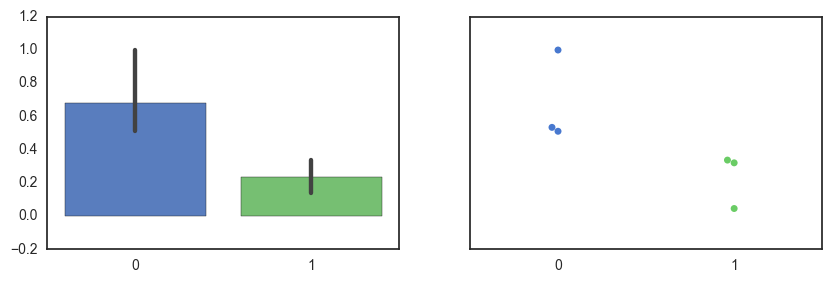

Executing the 3 measurements and ploting the results :: 8
Population A => 0.63 +- 0.35
Population B => 0.21 +- 0.063


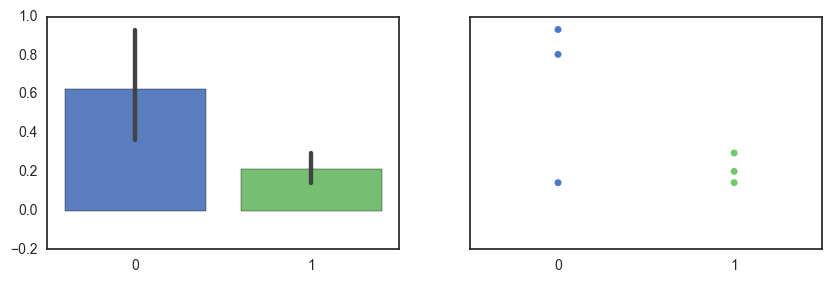

Executing the 3 measurements and ploting the results :: 9
Population A => 0.73 +- 0.26
Population B => 0.3 +- 0.31


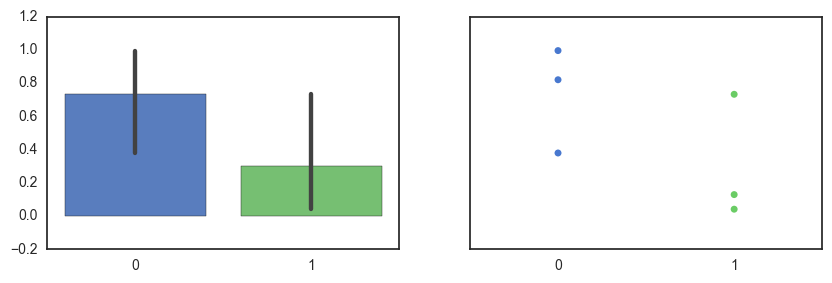

In [4]:
for i in range(10):
    print('Executing the 3 measurements and ploting the results :: {:}'.format(i))
    samplePops([A, B], 3)
    plotSample([A, B])